# Fine-mapping workflow using summary statistics

Here I implement a workflow that does summary statistics fine-mapping using SuSiE and DAP-G.

SuSiE is implemented in [`susieR`](https://github.com/stephenslab/susieR) (please use version 0.6.1+).

Since we need to analyze the data with both SuSiE and DAP-G we make input format compatible with DAP-G (SuSiE, implemented in R, is more flexible in input format).

update SoS and sos-notebook
```
cd ~/GIT/software/SoS
git pull
pip install ./
```

```
cd ~/GIT/
git clone https://github.com/stephenslab/susieR.git
cd susieR/
R
devtools::install_github("stephenslab/susieR")
# devtools::install_github("stephenslab/dsc", subdir = "dscrutils", force = TRUE)
```

```
sudo apt-get install libgsl-dev
```

```
cd ~/GIT/exec/
mv ../atac-gwas/dap-g ./
source .bashrc
```

In [5]:
%cd ~/GIT/github/fine-mapping

/home/gaow/Documents/GIT/github/fine-mapping

## The workflow

In [6]:
sos run summary_statistics_finemapping.ipynb -h

usage: sos run summary_statistics_finemapping.ipynb
               [workflow_name | -t targets] [options] [workflow_options]
  workflow_name:        Single or combined workflows defined in this script
  targets:              One or more targets to generate
  options:              Single-hyphen sos parameters (see "sos run -h" for details)
  workflow_options:     Double-hyphen workflow-specific parameters

Workflows:
  susie_bhat
  susie_z
  dap

Global Workflow Options:
  --cwd . (as path)
                        Current work directory, where output will be written to
  --loci . (as path)
                        Loci file
  --ss-data-prefix . (as path)
                        summary statistics file prefix
  --anno uniform
                        annotation
  --prior-file /tmp/file (as path)
                        FIXME: need to make it work for with anno
  --n 79845 (as int)
  --var-y 1 (as int)

Sections
  susie_bhat_1:         Run SuSiE bhat version
    Workflow Options:
      --su

In [1]:
[global]
# Current work directory, where output will be written to
parameter: cwd = path(".")
# Loci file
parameter: loci = path()
# summary statistics file prefix
parameter: ss_data_prefix = path()
# annotation
parameter: anno = "uniform"
# FIXME: need to make it work for with anno
parameter: prior_file = path('/tmp/file')
parameter: n = 79845 # sample size in GWAS data
parameter: var_y = 1

fail_if(not loci.is_file(), msg = 'Please specify valid path for --loci')
chunks = [x.strip().split() for x in open(f'{loci:a}').readlines() if not x.strip().startswith('#')]

def fmtP(x):
    return str(x).replace(".", "p").replace(' ', '_')
if not prior_file.exists():
    anno = "uniform"

### SuSiE $\hat{b}$ version

In [2]:
# Run SuSiE bhat version
[susie_bhat_1]
# Set prior effect to 0.0 to estimate from data
parameter: susie_prior_effect = 0.1
# Whether or not to estimate residual variance
parameter: susie_est_residual = True
# Set maximum number of effect variables
parameter: L = 5
# Whether or not to keep fit from each iteration,
# for debug purpose.
parameter: track_fit = False
#
suffix = f'SuSiE_B.L_{L}.prior_{fmtP(susie_prior_effect)}.res_var_{str(susie_est_residual).lower()}'
prior_str = f'read.table({prior_file:r})[,2]' if prior_file.exists() else 'NULL'
#
input: [f'{ss_data_prefix:a}.{x[3] if len(x) == 4 else "%s_%s_%s" % (x[0], x[1], x[2])}.summary_stats.txt' for x in chunks], group_by = 1
output: f'{_input:n}.{anno}.{suffix}.rds'
R: expand = '${ }', stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout'
    data = read.table(${_input:ar}, head = T)
    prior = ${prior_str}
    r = as.matrix(read.table("${_input:nn}.LD.txt"))
    bhat = data[,2]
    shat = data[,3]
    library(susieR)
    s = susie_bhat(bhat, shat, r, ${n}, var_y = ${var_y}, r_tol = 5e-3, L = ${L}, min_abs_corr = 0.1,
                  ${'estimate_prior_variance=TRUE' if susie_prior_effect == 0 else 'scaled_prior_variance=' + str(susie_prior_effect)},
                  ${'estimate_residual_variance=TRUE' if susie_est_residual else 'estimate_residual_variance=FALSE'},
                  prior_weights=prior, track_fit=${"T" if track_fit else "F"})
    s$prior = prior
    s$z = bhat / shat
    s$var_names = data[,1]
    if (${susie_prior_effect} == 0 && ${int(susie_est_residual)}) print(paste(c("Estimated PVE:", round(s$V/s$sigma2, 4)), collapse = ' '))
    if (${"T" if track_fit else "F"}) susie_plot_iteration(s, ${L}, ${_input:nr})
    saveRDS(s, ${_output:r})

### SuSiE $z$ version

In [3]:
# Run SuSiE Z score version
[susie_z_1]
# Set maximum number of effect variables
parameter: L = 5
# Whether or not to keep fit from each iteration,
# for debug purpose.
parameter: track_fit = False
#
suffix = f'SuSiE_Z.L_{L}'
prior_str = f'read.table({prior_file:r})[,2]' if prior_file.exists() else 'NULL'
#
input: [f'{ss_data_prefix:a}.{x[3] if len(x) == 4 else "%s_%s_%s" % (x[0], x[1], x[2])}.summary_stats.txt' for x in chunks], group_by = 1
output: f'{_input:n}.{anno}.{suffix}.rds'
R: expand = '${ }', stderr = f'{_output:n}.stderr', stdout = f'{_output:n}.stdout'
    data = read.table(${_input:ar}, head = T)
    prior = ${prior_str}
    r = as.matrix(read.table("${_input:nn}.LD.txt"))
    if (ncol(data) == 3) {
      bhat = data[,2]
      shat = data[,3]
      p_values = 2 * pt(-abs(bhat / shat), df = ${n} - 2)
      z_scores = abs(qnorm(p_values/2)) * sign(bhat)
    } else {
      z_scores = data[,2]
    }
        
    library(susieR)
    s = susie_z(z_scores, r, r_tol = 5e-3, L = ${L}, min_abs_corr = 0.1,
                  prior_weights=prior, track_fit=${"T" if track_fit else "F"})
    s$prior = prior
    s$z = z_scores
    s$var_names = data[,1]
    if (${"T" if track_fit else "F"}) susie_plot_iteration(s, ${L}, ${_input:nr})
    saveRDS(s, ${_output:r})

In [4]:
# Run DAP-G
[dap_1]
# Extra arguments to pass to DAP
parameter: args = ''
prefix = f'{out_prefix}.DAP{"."+fmtp(args) if len(args) else ""}'
input: data_file, ld_file
output: f'{prefix}.{anno}.pkl'
python: expand = '${ }', stderr = f'{_output:n}.stderr'
    import sys
    import pandas as pd
    import numpy as np
    import os
    import pickle

    def run_dap_ss(prefix, data_file, ld_file, n, varY, prior_file = None, args = ''):
        cmd = ['dap-g', '-d_est', data_file, '-d_ld', ld_file, '-d_n', n, '-d_syy', varY, '-o', f'{prefix}.result', '-l', f'{prefix}.stderr', '--all', args]
        if prior_file is not None and os.path.isfile(prior_file):
            cmd.extend(['-p', prior_file])
        cmd = ' '.join(map(str,cmd))
        sys.stderr.write(cmd + '\n')
        os.system(cmd)

    def extract_dap_output(prefix):
        out = [x.strip().split() for x in open(f'{prefix}.result').readlines()]
        pips = []
        clusters = []
        still_pip = True
        for line in out:
            if len(line) == 0:
                continue
            if len(line) > 2 and line[2] == 'cluster_pip':
                still_pip = False
                continue
            if still_pip and (not line[0].startswith('((')):
                continue
            if still_pip:
                pips.append([line[1], float(line[2]), float(line[3]), int(line[4])])
            else:
                clusters.append([len(clusters) + 1, float(line[2]), float(line[3])])
        pips = pd.DataFrame(pips, columns = ['snp', 'snp_prob', 'snp_log10bf', 'cluster'])
        clusters = pd.DataFrame(clusters, columns = ['cluster', 'cluster_prob', 'cluster_avg_r2'])
        clusters = pd.merge(clusters, pips.groupby(['cluster'])['snp'].apply(','.join).reset_index(), on = 'cluster')
        return {'snp': pips, 'set': clusters}

    run_dap_ss(${_output:anr}, ${data_file:ar}, ${ld_file:ar}, ${n}, ${var_y}, ${prior_file:ar}, ${args})
    res = extract_dap_output(${_output:anr})
    res['var_names'] = np.loadtxt(${data_file:ar}, dtype = str, usecols=0)
    ss = np.loadtxt(${data_file:ar}, dtype = float, usecols=(1,2))
    res['z'] = ss[:,0]/ss[:,1]
    res['prior'] = np.loadtxt(${prior_file:ar}, dtype = float, usecols=1)
    pickle.dump(res, open(${_output:ar}, 'wb'))

### Plot

In [5]:
# Summarize Fine-mapping results
[susie_bhat_2, susie_z_2, dap_2]
depends: R_library('dscrutils') # can be installed via `devtools::install_github("stephenslab/dsc",subdir = "dscrutils", force = TRUE)`
output: f'{_input:n}.pdf'
R: expand = '${ }', stderr = f'{_output:n}.log'
    s = dscrutils::read_dsc(${_input:r})
    # print something to log
    write(format(Sys.time(), "%a %b %d %X %Y"), stderr())
    library(susieR)
    is_susie = !is.null(s$elbo)
    if (is_susie) {
        write(paste('SuSiE objective:', susie_get_objective(s), "at L =", nrow(s$alpha)), stderr())
    } else {
        snp = s$snp
        snp = snp[match(s$var_names, snp$snp),]
        s$pip = snp$snp_prob
        class(s) = 'susie'
    }
    # make some plots
    pdf(${_output:r}, 8,9,pointsize=16)
    par(mar=c(2,4,0,0), omi=c(0,0,0,0), oma=c(0,0,0,0),mfrow=c(2,1))
    susie_plot(s,y='PIP')
    susie_plot(s,y='z')
    dev.off()
    ordering = order(s$pip, decreasing=T)
    if (is.null(s$prior)) s$prior = rep(1/length(ordering),length(ordering))
    for (i in 1:5) {
        write(paste0("#", i, " pip-ranked SNP ", s$var_names[ordering[i]], " has z-score ", 
              round(s$z[ordering[i]],2), " pip ", round(s$pip[ordering[i]],4), " and prior ", round(s$prior[ordering[i]],4)), stderr())
    }
    ordering = order(abs(s$z), decreasing=T)
    for (i in 1:5) {
        write(paste0("#", i, " z-ranked SNP ", s$var_names[ordering[i]], " has z-score ", 
              round(s$z[ordering[i]],2), " pip ", round(s$pip[ordering[i]],4), " and prior ", round(s$prior[ordering[i]],4)), stderr())
    }

## SuSiE $B$

In [ ]:
sos run summary_statistics_finemapping.ipynb susie_bhat \
        --loci /home/gaow/tmp/19-Dec-2018/1KG_EUR/chunks.list \
        --ss-data-prefix /home/gaow/tmp/19-Dec-2018/SCZ/summary_stats/Summary_statistics \
        --susie-prior-effect 0 --anno atac-seq --L 5

%preview /home/gaow/tmp/19-Dec-2018/SCZ/summary_stats/Summary_statistics.chr9_1785000_1790000.summary_stats.uniform.SuSiE_B.L_5.prior_0p0.res_var_true.pdf

> /home/gaow/tmp/19-Dec-2018/SCZ/summary_stats/Summary_statistics.chr9_1785000_1790000.summary_stats.uniform.SuSiE_B.L_5.prior_0p0.res_var_true.pdf (4.8 KiB):

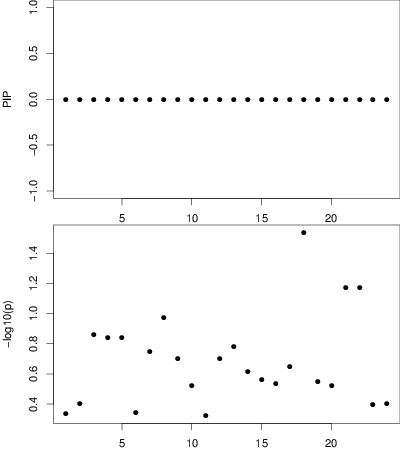

In [4]:
%preview /home/gaow/tmp/19-Dec-2018/SCZ/summary_stats/Summary_statistics.chr9_1785000_1790000.summary_stats.uniform.SuSiE_B.L_5.prior_0p0.res_var_true.pdf -s png --dpi 50

## SuSiE $Z$